In [1]:
import numpy as np
import sys
import warnings
import emcee
import matplotlib.pyplot as plt
from bioscrape.types import Model, read_model_from_sbml
from bioscrape.simulator import ModelCSimInterface, DeterministicSimulator, SSASimulator

def import_timeseries(filename, time_column, value_column, properties = {}, plot_show = False):
    '''
    filename : csv file with columns for data values 
    (The column numbers start at 1)
    time_column : the column number in the file that has all the time series indexes that you want to import
    value_column : the column number in the file that has all the corresponding values that you want to import 
    properties : Optional dictionary to specify other properties that the imported data must satisfy. For example, 
    properties = {3 : 'abc'}, would only impor those rows that have column 3 value equal to 'abc'
    '''
    try:
        import csv
        from operator import itemgetter
        from itertools import groupby
        import math
    except:
        print('Packages not found. Make sure csv, operator, itertool, and math are installed.')

    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        data_dict = {}
        for row in csv_reader:
            if row and row[time_column - 1] and row[value_column - 1]:
                if properties:
                    for col, value in properties.items():
                        if row[col - 1] == str(value):
                            data_dict[float(row[time_column - 1])] = float(row[value_column - 1])
                        else:
                            break 
                else:
                    cell_t = row[time_column - 1]
                    cell_v = row[value_column - 1]
                    temp_str_t = cell_t.replace('.','',1).replace('e','',1).replace('-','',1)
                    temp_str_v = cell_v.replace('.','',1).replace('e','',1).replace('-','',1)
                    if temp_str_t.isdigit() and temp_str_v.isdigit():
                        data_dict[float(cell_t)] = float(cell_v)
        data_obj = Data(filename, 'timeseries', data_dict)
        time = list(data_obj.get_keys())
        values = list(data_obj.get_values())
        if plot_show:
            try:
                import matplotlib.pyplot as plt
            except:
                raise Exception('matplotlib not installed.')
            max_time = math.floor(max(time))
            index = []
            for i in range(len(time)):
                if int(math.floor(float(time[i]))) == max_time:
                    index.append(i)
            final_index = []
            for k, g in groupby(enumerate(index), lambda x:x[1]-x[0]):
                map_t = map(itemgetter(1), g)
                final_index.append(max(map_t)+1)
            init_time_index = 0
            for i in final_index:
                plt.plot(time[init_time_index:i],values[init_time_index:i])
                plt.show()
                init_time_index = i
    return data_obj
    
def import_distribution(filename, index_column, value_column, properties = {}, plot_show = False):
    '''
    TODO: To be implemented
    ''' 
    return

class Data:
    def __init__(self, name, type, data = {}):
        '''
        name : string representing the name of the data set 
        type : type of data set - whether time series (Use string 'timeseries') or distributional (use 'distrib')
        data : dictionary with key and value for the data
        '''
        self.name = name
        self.type = type
        self.data = data 

    def get_keys(self):
        '''
        Returns the key list of the data dictionary
        '''
        return list(self.data.keys())

    def get_values(self):
        '''
        Returns the values list of the data dictionary
        '''
        return list(self.data.values())

    
class StochasticInference(object):
    def __init__(self):
        self.m = None
        self.sbml = None
        self.params_to_estimate = {}
        self.prior = None
        self.nwalkers = 100
        self.nsteps = 1000
        self.nsamples = 500
        self.dimension = 0
        self.cost = 'L2norm'
        self.penalty = 1
        self.exp_data = None
        self.timepoints = []
        self.measurements = ['']
        self.species = {}
        self.parameters = {}
        return 

    def set_prior(self, prior):
        self.prior = prior
        return self.prior

    def get_parameters(self):
        return self.params_to_estimate

    def get_prior(self):
        return self.prior
   
    def log_prior(self, param_dict, prior):
        for key,value in param_dict.items():
            range = prior[key]
            if value > max(range) or value < min(range):
                return False
        return True
        
    
    def log_likelihood(self, log_params):
        measurements = self.measurements
        timepoints = self.timepoints
        nsamples = self.nsamples
        exp_data = self.exp_data
        cost = self.cost
        penalty = self.penalty
        param_dict = {}
        params_exp = np.exp(log_params)
        for key, p in zip(self.parameters.keys(),params_exp):
            param_dict[key] = p
        prior = self.get_prior()
        # Check prior
        if self.log_prior(param_dict, prior) == False:
            return -np.inf
        
        # Simulate for each sample in nsample and store the result for the desired output species in result array
        if self.sbml:
            try:
                import libsbml
            except:
                print('python-libsbml must be installed to use SBML models')
            filename = 'temp_simulate.xml'
            libsbml.writeSBML(self.sbml,filename)
            self.m = read_model_from_sbml(filename)
            m = self.m
            outputs = []
            for species in measurements:
                outputs.append(m.get_species_index(species))
#             print('outputs are')
#             print(outputs)
            results = np.zeros((len(timepoints), len(outputs), nsamples))
#             print('the shape of results is')
#             print(np.shape(results))
            for sample in range(nsamples):
                sim, m = self.simulate(timepoints, type = 'stochastic')
                for i in range(len(outputs)):
                    out = outputs[i]
                    results[:,i,sample] = sim[:,out]
#             print('the results have now been filled in after simulation')
#             print(results)
        else:
            raise NotImplementedError('SBML models only (for now)!')

        # Error calculation here
#         print('the experimental data has shape')
#         print(np.shape(exp_data.get_values()))
#         print('the actual experimental data values are ')
#         print(exp_data.get_values())
        total_error = 0
        for i in range(len(outputs)):
#             print('for output- ')
#             print(outputs[i])
#             print('we have nsamples ')
            for j in range(nsamples):
                d1 = results[:,i,j]
#                 print('the shape of result : i, j is')
#                 print(np.shape(d1))
                diff = np.abs(d1 - exp_data.get_values()[i]) 
                if cost == 'inf':
                    infinity_error = np.max(diff)
                    total_error += infinity_error**2
                elif cost == 'L2norm':
                    L2_norm_error = diff**2
                    L2_norm_error = np.linalg.norm(diff)
                    total_error += L2_norm_error
        return -total_error*penalty
    
    def prepare_mcmc(self, **kwargs):
        
        timepoints = kwargs.get('timepoints')
        exp_data = kwargs.get('exp_data')
        params = kwargs.get('params')
        prior = kwargs.get('prior')
        nwalkers = kwargs.get('nwalkers')
        nsamples = kwargs.get('nsamples')
        nsteps = kwargs.get('nsteps')
        log_likelihood = kwargs.get('log_likelihood')
        penalty = kwargs.get('penalty')
        cost = kwargs.get('cost')
        measurements = kwargs.get('measurements')

        if timepoints.size:
            self.timepoints = timepoints
        if exp_data:
            self.exp_data = exp_data
        if params:
            self.params_to_estimate = params
        if prior:
            self.prior = prior
        if nwalkers:
            self.nwalkers = nwalkers
        if nsamples:
            self.nsamples = nsamples    
        if nsteps:
            self.nsteps = nsteps
        if log_likelihood:
            self.log_likelihood = log_likelihood
        if penalty:
            self.penalty = penalty
        if cost:
            self.cost = cost
        if measurements:
            self.measurements = measurements

        
    def run_mcmc(self, **kwargs):
        plot_show = kwargs.get('plot_show')
        if not plot_show:
            plot_show = False
        try:
            import emcee
        except:
            print('emcee package not installed')
        ndim = len(self.params_to_estimate)
        p0 = []
        for walker in range(self.nwalkers):
            plist = []
            ploglist = []
            for key, value in self.params_to_estimate.items():
                pinit = np.random.normal(value, 0.25*value)
                plist.append(pinit)
                ploglist.append(np.log(pinit))
            p0.append(np.array(plist))   
            print('Sample log-like: {0}'.format(self.log_likelihood(np.array(ploglist))))

        sampler = emcee.EnsembleSampler(self.nwalkers, ndim, self.log_likelihood)
        # for i, junk in enumerate(sampler.sample(p0, iterations=nsteps)):
        #     print('Step %d' % i)
        # TODO: Add progress percentage update display code here 
        sampler.run_mcmc(p0, self.nsteps)    
        # Write results
        import csv
        with open('mcmc_results.csv','w', newline = "") as f:
            writer = csv.writer(f)
            writer.writerows(sampler.flatchain)
            f.close()
        print('Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file')
        fitted_model, params = self.plot_mcmc_results(sampler, plot_show)
        return fitted_model, params
    
    def plot_mcmc_results(self, sampler, plot_show = True):
        best_p = []
        for i in range(len(self.params_to_estimate)):
            my_list = [tup[i] for tup in sampler.flatchain]
            new_list = []
            for x in my_list:
                if x > 0:
                    new_list.append(x)
            if plot_show:
                n, bins, patches = plt.hist(new_list, density = True, histtype = "bar")
            else:
                fig = plt.figure()
                n, bins, patches = plt.hist(new_list, density = True, histtype = "bar")
                plt.close(fig)
            # n, bins, patches = plt.hist(new_list, density = True, bins = 80, histtype = "bar")
            # Find best p
            best_p_ind = np.where(n == np.max(n))
            best_p.append(bins[best_p_ind])
            # Plot
            if plot_show:
                plt.savefig('parameter - ' + str(list(self.params_to_estimate.keys())[i]) +' .svg')
                plt.show()

        # Write fitted model
        best_p = list(best_p)
        fitted_model = self
        params_names = list(fitted_model.params_to_estimate.keys())
        params = {}
        for i in range(len(params_names)):
            p_name = params_names[i]
            p_sampled_value = best_p[i]
            params[p_name] = p_sampled_value

        fitted_model.parameters = params
        # Simulate again 
        fitted_model.simulate(timepoints, type = 'stochastic', species_to_plot = self.measurements, plot_show = plot_show)
        return fitted_model, params
    
    def simulate(self, timepoints, **kwargs):
        ''' 
        To simulate using bioscrape.
        '''
        type = kwargs.get('type')
        species_to_plot = kwargs.get('species_to_plot')
        plot_show = kwargs.get('plot_show')
        if not plot_show:
            plot_show = False
        if self.sbml:
            try:
                import libsbml
            except:
                print('libsbml-python must be installed to use SBML models')
            # If SBML model,
            filename = 'temp_simulate.xml'
            libsbml.writeSBML(self.sbml, filename) 
            m = read_model_from_sbml(filename)
            s = ModelCSimInterface(m)
            if type == 'deterministic':
                s.py_prep_deterministic_simulation()
                s.py_set_initial_time(timepoints[0])
                sim = DeterministicSimulator()
                result = sim.py_simulate(s, timepoints)
                result = result.py_get_result()
                if plot_show:
                    for species in species_to_plot:
                        ind = m.get_species_index(species)
                        plt.plot(timepoints,result[:,ind])
                    plt.title(str(species_to_plot) + ' vs time')
                    plt.show()
                return result, m
            elif type == 'stochastic':
                warnings.warn('For stochastic simulation of SBML models using bioscrape, it is highly recommended to NOT use reversible reactions as the SSA algorithm might not work for such cases.')
                sim = SSASimulator()
                s.py_set_initial_time(timepoints[0])
                result = sim.py_simulate(s,timepoints)
                result = result.py_get_result()
                if plot_show:
                    for species in species_to_plot:
                        ind = m.get_species_index(species)
                        plt.plot(timepoints,result[:,ind])
                    plt.title(str(species_to_plot) + ' vs time')
                    plt.show()
                return result, m
            else:
                raise ValueError('Optional argument "type" must be either deterministic or stochastic')

        elif self.m:
            # If bioscrape model
            m = self.m
            s = ModelCSimInterface(m)
            if type == 'deterministic':
                s.py_prep_deterministic_simulation()
                s.py_set_initial_time(timepoints[0])
                sim = DeterministicSimulator()
                result = sim.py_simulate(s, timepoints)
                result = result.py_get_result()
                if plot_show:
                    for species in species_to_plot:
                        ind = m.get_species_index(species)
                        plt.plot(timepoints,result[:,ind])
                    plt.title(str(species_to_plot) + ' vs time')
                    plt.show()
                return result, m
            elif type == 'stochastic':
                warnings.warn('For stochastic simulation of SBML models using bioscrape, it is highly recommended to NOT use reversible reactions as the SSA algorithm might not work for such cases.')
                sim = SSASimulator()
                s.py_set_initial_time(timepoints[0])
                result = sim.py_simulate(s,timepoints)
                result = result.py_get_result()
                if plot_show:
                    for species in species_to_plot:
                        ind = m.get_species_index(species)
                        plt.plot(timepoints,result[:,ind])
                    plt.title(str(species_to_plot) + ' vs time')
                    plt.show()
                return result, m
            else:
                raise ValueError('Optional argument "type" must be either deterministic or stochastic')

    def export_sbml(self, filename):
        try:
            import libsbml
        except:
            print('libsbml-python must be installed to use SBML models')
        if self.sbml:
            model = self.sbml.getModel()
            params = self.params_to_estimate
            for pid,pval in params.items():
                if isinstance(pval, (list, np.ndarray)):
                    pval = pval[0]
                model.getElementBySId(pid).setValue(float(pval))
            libsbml.writeSBML(self.sbml,filename)
        elif self.m:
            model_doc = self.m.convert_to_sbml()

            libsbml.writeSBML(model_doc, filename)
        else:
            raise ValueError('Model must be SBML or bioscrape XML. Other models not supported.')

    def import_sbml(self, filename):
        try:
            import libsbml
        except:
            print('Unable to import libsbml. Make sure that python-libsbml package is installed and working')
        reader = libsbml.SBMLReader()
        doc = reader.readSBML(filename)
        self.sbml = doc
        params_dict = {}
        species_dict = {}
        # Get global parameters
        for param in doc.getModel().getListOfParameters():
            params_dict[param.getId()] = param.getValue()
        count = 0
        # Get local parameters
        for reaction in doc.getModel().getListOfReactions():
                for param in reaction.getKineticLaw().getListOfLocalParameters():
                    count = count + 1
                    params_dict[param.getId() + '_local_' + reaction.getId() + str(count)] = param.getValue()
        self.parameters = params_dict

        for species in doc.getModel().getListOfSpecies():
            species_dict[species.getId()] = species.getInitialAmount()

        self.species = species_dict
        return self.sbml



c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:347: UserWarning: For stochastic simulation of SBML models using bioscrape, it is highly recommended to NOT use reversible reactions as the SSA algorithm might not work for such cases.


Sample log-like: -196.57537885350763
Sample log-like: -195.46069401846034
Sample log-like: -202.95348291608798
Sample log-like: -199.80778795836372
Sample log-like: -200.38770316616066
Sample log-like: -197.94309133289676
Sample log-like: -199.09822778893084
Sample log-like: -200.65608672283662
Sample log-like: -197.48439564347393
Sample log-like: -199.79003196828722
Sample log-like: -205.71668287450436
Sample log-like: -204.25032581212997
Sample log-like: -196.52811664395463
Sample log-like: -203.44767531741326
Sample log-like: -200.88249183414797
Sample log-like: -195.3725239584991
Sample log-like: -199.6431963435462
Sample log-like: -194.98582469932455
Sample log-like: -200.20908467404652
Sample log-like: -198.11013772756758
Sample log-like: -200.61275678929354
Sample log-like: -201.35315918819538
Sample log-like: -200.33934475778474
Sample log-like: -202.85189039425083
Sample log-like: -196.90340528924833
Sample log-like: -202.7472303794015
Sample log-like: -199.13577286645545
Samp

c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\emcee\ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\emcee\ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file


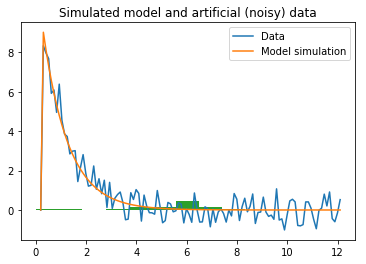

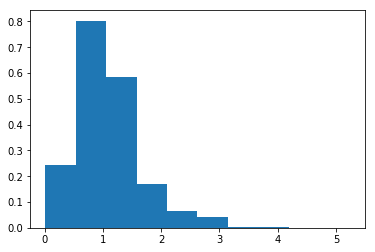

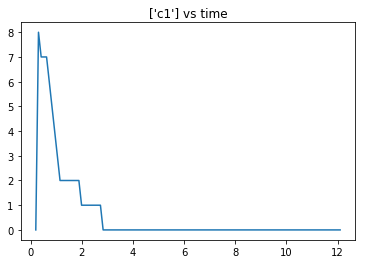

In [4]:
%matplotlib inline

# Create an empty StochasticInference object to initiate the inference procedure
spid = StochasticInference()

# Import a model that you want to use for inference
spid.import_sbml('sbml_example.xml')
import numpy as np
import matplotlib.pyplot as plt  
data = import_timeseries('test_data.csv', time_column = 2, value_column = 4, properties = {3 : 51})
t_exp = data.get_keys()
timepoints = np.linspace(t_exp[0],t_exp[-1],len(t_exp))
bs_data, m = spid.simulate(timepoints, type = 'deterministic')
simtime = timepoints
simdata = bs_data[:,m.get_species_index('c1')]
# simtime, simdata = model.simulate_roadrunner(timepoints)

# Create artificial data for model to test the code
# SKIP this part you already have your data, store it inside exp_data

lines = []
exp_value = []
for t,d in zip(simtime, simdata):
    v = d + np.random.normal(0,0.5)
    exp_value.append(v)
    lines.append([t,v])
import csv 
with open('test_data_noisy.csv','w') as f:
    writer = csv.writer(f)
    writer.writerows(lines)
    f.close()

plt.plot(simtime, exp_value, label = 'Data')
plt.plot(simtime, simdata, label = 'Model simulation')
plt.legend()
plt.title('Simulated model and artificial (noisy) data')



# Parameter identification using MCMC
# Specify the priors for the parameters
spid.prior = {'kc' : [1e-3, 1e3],'k1' : [1e-2, 1e5]}
# Initial guesses for the parameters to estimate
spid.params_to_estimate = {'kc':6, 'k1':1}

spid.prepare_mcmc(params = spid.params_to_estimate, prior = spid.prior, timepoints = timepoints, 
                  exp_data = data, nwalkers = 40, nsteps = 100, nsamples = 5, measurements = ['c1'])
fit_model, id_params = spid.run_mcmc(plot_show = True)
# fit_model is with identified parameters' "best" value substituted


In [ ]:
spid.nsamples